# Grad-CAM Heatmap to Spectrogram Conversion for Waveform-Input Models

Title: **Exploring the Fusion of Visualization and Audio Analysis: Grad-CAM Heatmap to Spectrogram Conversion for Waveform-Input Models**

Introduction:

The advent of deep learning in audio signal processing has revolutionized how we analyze, understand, and manipulate sound. Models that take raw waveforms as input have shown remarkable performance in tasks ranging from speech recognition to music genre classification. However, interpreting these "black box" models remains a challenge. This is where techniques like Gradient-weighted Class Activation Mapping (Grad-CAM) come into play, providing visual explanations for the decisions made by convolutional neural networks (CNNs). 

Grad-CAM generates heatmaps that highlight the regions in the input image that are most relevant for predicting a particular class. While originally designed for image classification tasks, adapting Grad-CAM for waveform-input models introduces a unique challenge: translating the spatial significance of an image to the temporal and frequency dimensions of audio. Here, we propose an innovative approach to convert Grad-CAM heatmaps into spectrograms, which are visual representations of the spectrum of frequencies of a signal as it varies with time. This conversion not only bridges the gap between the visual interpretation tools of image processing and the domain of audio analysis but also provides a novel way to interpret how waveform-input models make their decisions.

**Why Convert Grad-CAM Heatmaps to Spectrograms?**

1. **Enhanced Interpretability:** By converting the heatmaps to spectrograms, we can directly correlate the model's focus areas with the actual audio features, making it easier for audio engineers, researchers, and even musicians to understand what aspects of the sound the model is attending to.

2. **Temporal and Frequency Analysis:** Spectrograms allow us to see how the importance of different frequency components changes over time, which is crucial for understanding dynamic audio signals like music or speech.

3. **Model Debugging and Improvement:** This conversion can help in identifying whether the model is focusing on the right audio features for classification, which can lead to better model design, training, and feature engineering.

4. **Educational and Creative Applications:** The visual representation of what a model 'hears' can be used in educational contexts to teach about audio signal processing or in creative applications where artists can interact with AI in new ways.

In this paper, we will delve into the methodology behind converting Grad-CAM heatmaps to spectrograms, discuss the implications for waveform-input models, and explore potential applications. This work aims to push the boundaries of model interpretability, combining the strengths of visual and auditory analysis to foster a deeper understanding of how deep learning models perceive and process audio data.

## Introduction

This notebook demonstrates:
- how to apply the **Grad-CAM** technique to generate a heatmap for a waveform-input model, and subsequently
- convert the heatmap of the waveform into a spectrogram using Torch.

The notebook guides through the process of installing necessary libraries, importing required libraries and loading a dataset of waveforms, defining a PyTorch model that takes waveforms as input, applying Grad-CAM to generate a heatmap, converting the heatmap into a spectrogram with Torch, and finally visualizing the resulting spectrogram using a library like matplotlib or seaborn.

## Import Libraries and Load Data

In [168]:
# Import necessary libraries
import torch
import torchvision
import numpy as np  # for numerical computations
import matplotlib.pyplot as plt  # for plotting (optional)
from torch.utils.data import DataLoader

In [169]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [170]:
from ay2.torch.data.audio import WaveDataset

### Load data

We use Codecfake dataset for testing.

In [171]:
from ay2.datasets.audio import Codecfake_AudioDs
from ay2.datasets.audio._codecfake import ROOT_PATH as Codecfake_Root_path

In [172]:
codecfake = Codecfake_AudioDs(root_path=Codecfake_Root_path)
# We only use the first 5 samples in codecfake.
ds = WaveDataset(data=codecfake.data.iloc[0:5])

/usr/local/ay_data/packages2/ay2/datasets/base.py:78: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data_path)


In [174]:
ds[0]

{'sample_rate': 16000,
 'label': 0,
 'name': '/mnt/data1/zky/Codecfake16k/test/A1/L1_p225_004.wav',
 'vocoder_label': 8,
 'speed_label': 5,
 'compression_label': 0,
 'audio': tensor([[ 0.0005,  0.0004,  0.0003,  ..., -0.0005, -0.0005, -0.0004]])}

Look the first element of the `ds`. As can be seen, the data structure is 
```python
{'sample_rate': audio fps,
 'label': 0 or 1,
 'name':  path of audio,
 'vocoder_label': 8,
 'speed_label': 5,
 'compression_label': 0,
 'audio': torch.Tensor with shape of (1, L)
}
```

## Define Waveform-Input Model

We use the AASIST model that uses 1D waveform as input for presentation.

In [175]:
import sys
sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio")

from models.Aaasist import AASIST_lit

In [176]:
model = AASIST_lit(ckpt_path="/home/ay/data/DATA/1-model_save/00-Deepfake/1-df-audio/AASIST/Codecfake/version_0/checkpoints/best-epoch=1-val-auc=0.9999.ckpt")
model = model.model

no. model params:297705


In [119]:
for x in model.named_modules():
    print(x)

('', Model(
  (conv_time): CONV()
  (first_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=True)
  (drop_way): Dropout(p=0.2, inplace=True)
  (selu): SELU(inplace=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): Residual_block(
        (conv1): Conv2d(1, 32, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
        (selu): SELU(inplace=True)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(2, 3), stride=(1, 1), padding=(0, 1))
        (conv_downsample): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (mp): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Sequential(
      (0): Residual_block(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(2

### Example input and output

Note that AASIST model's forward method returns both the feature and logits.

In [177]:
x = torch.randn(2, 48000)
feat, logits = model(x)
print("Feature shape: ", feat.shape, "\nLogit shape:", logits.shape)

Feature shape:  torch.Size([2, 160]) 
Logit shape: torch.Size([2, 1])


## Apply Grad-CAM Technique to Generate Heatmap

In [178]:
# Import necessary libraries
from pytorch_grad_cam import GradCAM
import matplotlib.pyplot as plt
import cv2

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from ay2.tools.image import read_image

In [17]:
def plot_cam(x, grayscale_cam):
    
    mask = grayscale_cam
    heatmap = mask[0, 0]
    image_weight = 0.5
    print(grayscale_cam.shape, heatmap.shape, x.shape)
    heatmap = heatmap - np.mean(heatmap)
    plt.plot(x)
    cam = (1 - image_weight) * heatmap + image_weight * x
    plt.plot(cam)
    return mask

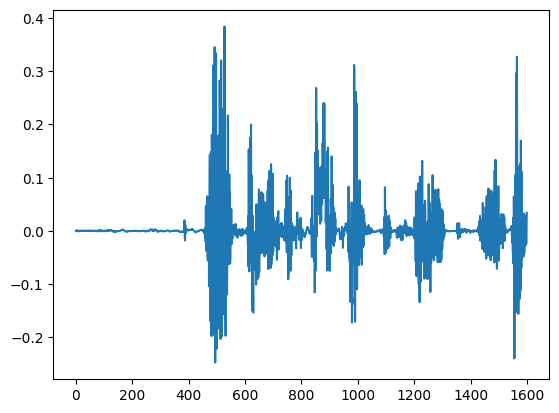

[[[0. 0. 0. ... 0. 0. 0.]]]
(1, 1, 48000) (48000,) (48000,)


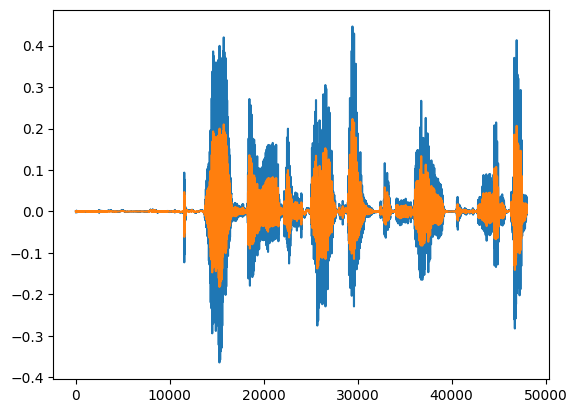

In [50]:
def get_cam(target_layers, x, target_class=0):
    input_tensor = x
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    return grayscale_cam
    
for i, sample in enumerate(ds):
    x = sample['audio'][:, :48000]

    plt.plot(x[0, ::30])
    plt.show()
    # plt.savefig('plot.png')
    
    target_layers = [model.encoder[0]]
    cam = get_cam(target_layers, x, target_class=sample['label'])
    print(cam)
    cam = plot_cam(x[0].numpy(), cam)
    break

In [140]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

def compute_cam_1d_output(model, data, layer_name, N):
    """
    Computes Grad-CAM++ for 1D data.
    
    Args:
        model: PyTorch model.
        data: Input data (torch.Tensor) with shape (B, L).
        layer_name: Name of the target layer for explanation.
        N: Signal length in seconds.
    
    Returns:
        Heatmap visualization of Grad-CAM++.
    """
    # Hooks to store activations and gradients
    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # Get the target layer
    target_layer = dict(model.named_modules())[layer_name]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.eval()
    data.requires_grad = True
    feat, predictions = model(data)
    print(predictions.shape)
    class_idx = torch.sigmoid(predictions) > 0.5
    y_c = predictions

    # Backward pass
    model.zero_grad()
    y_c.backward(retain_graph=True)

    # Compute derivatives
    grads = gradients.detach()
    first = F.relu(grads)
    second = F.relu(grads.pow(2))
    third = F.relu(grads.pow(3))

    print("first:", first.shape, "second:", second.shape, "third:", third.shape)
    
    
    
    # Compute saliency maps for the class_idx prediction
    print("Compute saliency maps on the activations:", activations.shape)
    global_sum = activations.sum(dim=(1), keepdim=True)
    alpha_num = second
    alpha_denom = second * 2.0 + third * global_sum
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    # Normalize alphas
    alpha_normalization_constant = alphas.sum(dim=(1), keepdim=True)
    alphas /= alpha_normalization_constant
    print('alpha', alphas.shape)
    alphas_thresholding = torch.where(first > 0.0, alphas, torch.zeros_like(alphas))

    # Re-normalize
    alpha_normalization_constant_processed = alphas_thresholding.sum(dim=(1), keepdim=True)
    alpha_normalization_constant_processed = torch.where(alpha_normalization_constant_processed != 0.0,
                                                          alpha_normalization_constant_processed,
                                                          torch.ones_like(alpha_normalization_constant_processed))
    alphas /= alpha_normalization_constant_processed

    # Compute deep linearization weights and Grad-CAM++ map
    deep_linearization_weights = (first * alphas).sum(dim=(0, 1))
    grad_CAM_map = (deep_linearization_weights.unsqueeze(0) * activations[0]).sum(dim=0)

    print('grad cam shape:', grad_CAM_map.shape)
    
    # Normalize the heatmap
    cam = grad_CAM_map.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam /= np.max(cam) if np.max(cam) != 0 else 1

    print(cam.shape, cam)

    # Turn result into a heatmap
    heatmap = []
    heatmap.append(cam.tolist())
    big_heatmap = cv2.resize(np.array(heatmap), dsize=(data.shape[1], 500), interpolation=cv2.INTER_CUBIC)
    x = np.linspace(0, N, data.shape[1])
    plt.style.use("seaborn-v0_8-whitegrid")
    multicolored_lines(x, data.detach().numpy()[0], big_heatmap[0], f"GradCAM++ Visualization")

/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([1, 1])
first: torch.Size([1, 14, 64]) second: torch.Size([1, 14, 64]) third: torch.Size([1, 14, 64])
Compute saliency maps on the activations: torch.Size([1, 14, 64])
alpha torch.Size([1, 14, 64])
grad cam shape: torch.Size([64])
(64,) [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6308961e-04
 0.0000000e+00 1.5959971e-01 1.3787380e-02 0.0000000e+00 3.0987415e-01
 3.4258191e-02 4.7686845e-02 0.0000000e+00 0.0000000e+00 2.4657397e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3256773e-01 0.0000000e+00
 2.7324140e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0781900e-01
 4.9270347e-02 0.0000000e+00 0.0000000e+00 2.6566726e-03 3.2803625e-01
 5.8466867e-02 2.0254691e-01 2.2949914e-03 0.0000000e+00 0.0000000e+00
 3.0543132e-02 2.6232910e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0232812e-01 0.0000000e+00 0.0000000e+00 1.5367396e-01
 1.9251670e-01 0.0000000e+00 1.4322495e-01

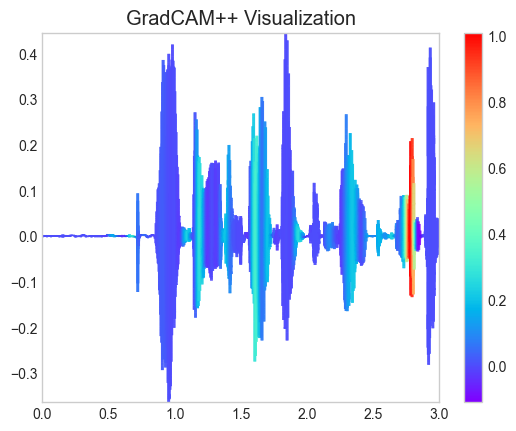

In [145]:
compute_cam_1d_output(model, sample['audio'][:, 0:48000], 'pool_T', 3)

In [100]:
import seaborn as sns
sns.set_style("whitegrid")
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [44]:
cam = cam[0, 0, :]
# cam = np.maximum(cam, 0)
# cam = cam / ( np.max(cam) + 1e-9)

In [91]:
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib as mpl
def multicolored_lines(x,y,heatmap,title_name):
    print(x.shape, y.shape, heatmap.shape)
    fig, ax = plt.subplots()
    lc = colorline(x, y, heatmap,cmap='rainbow')
    plt.colorbar(lc)
    lc.set_linewidth(2)
    lc.set_alpha(0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.title(title_name)
    plt.grid(False)
    plt.show()

def colorline(x, y, heatmap, cmap='rainbow'):
    z = np.array(heatmap)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc


## Convert Waveform Heatmap into Spectrogram

In [ ]:
Here's an improved version of your code:

In [ ]:
# Convert Waveform Heatmap into Spectrogram
# ======================================

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
def heatmap_to_spectrogram(heatmap: torch.Tensor,
                         n_fft: int = 2048,
                         hop_length: int = 512,
                         win_length: int = 2048) -> torch.Tensor:
    """
    Convert a waveform heatmap into a spectrogram.

In [ ]:
    Args:
        heatmap (torch.tensor): Heatmap of shape [1, timesteps]
        n_fft (int, optional): Size of FFT window. Defaults to 2048.
        hop_length (int, optional): Hop length between successive frames. Defaults to 512.
        win_length (int, optional): Window size. Defaults to 2048.

In [ ]:
    Returns:
        spectrogram (torch.tensor): Spectrogram of shape [1, freq_bins, time_steps]
    """
    # Pad the heatmap to ensure it can be divided evenly by hop_length
    padded_heatmap = torch.nn.functional.pad(heatmap, (0, -heatmap.shape[-1] % hop_length))

In [ ]:
    # Compute Short-Time Fourier Transform (STFT)
    window = torch.hamming_window(win_length).to(padded_heatmap.device)
    stft = torch.stft(padded_heatmap.squeeze(), n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window, onesided=True,
                     pad_mode='constant', normalized=False)

In [ ]:
    # Get the magnitude of the complex-valued STFT
    spectrogram = stft.abs().unsqueeze(0)  # Add batch dimension

In [ ]:
    return spectrogram

In [ ]:

# Load or generate the heatmap
heatmap: torch.Tensor = ...  

In [ ]:
# Convert the heatmap to spectrogram
spectrogram = heatmap_to_spectrogram(heatmap)

In [ ]:
print(spectrogram.shape)

In [ ]:
Note that I have used type hints for function arguments and returns. The `heatmap` is expected to be of type `torch.Tensor`. The `n_fft`, `hop_length` and `win_length` are optional parameters with default values.

## Visualize the Resulting Spectrogram

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported for array operations

In [ ]:
def visualize_spectrogram(spectrogram, cmap='inferno'):
    """
    Visualize the resulting spectrogram.

In [ ]:
    Parameters:
    - spectrogram (2D numpy array): The spectrogram data to be visualized.
    - cmap (str or matplotlib colormap, optional): Colormap to use for visualization. Defaults to 'inferno'.
    """
    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(12, 6))

In [ ]:
    # Use seaborn's heatmap function to create the spectrogram visualization
    sns.heatmap(spectrogram, cmap=cmap, ax=ax)

In [ ]:
    # Set title and labels for the plot
    ax.set_title('Resulting Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

In [ ]:
    # Display the plot
    plt.tight_layout()  # Ensure plot fits within figure area
    plt.show()

In [ ]:
# Example usage:
spectrogram_data = np.random.rand(256, 512)  # Replace with actual spectrogram data
visualize_spectrogram(spectrogram_data)

# Test 1

In [179]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def target_category_loss(x, category_index, nb_classes):
    return torch.mul(x, F.one_hot(category_index, nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (torch.sqrt(torch.mean(torch.square(x))) + 1e-5)


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = []
        self.activations = []

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        self.gradients = [grad_output[0]] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)


class BaseCAM:
    def __init__(self, model, target_layer, use_cuda=False):
        self.model = model.eval()
        self.target_layer = target_layer
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.activations_and_grads = ActivationsAndGradients(self.model, target_layer)

    def forward(self, input_img):
        return self.model(input_img)

    def get_cam_weights(self,
                        input_tensor,
                        target_category,
                        activations,
                        grads):
        raise Exception("Not Implemented")

    def get_loss(self, output, target_category):
        # print(output.size())
        # return output[target_category]
        return torch.sigmoid(output)

    def __call__(self, input_tensor, target_category=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        feat, output = self.activations_and_grads(input_tensor)

        if target_category is None:
            output = output.squeeze()
            target_category = np.argmax(output.cpu().data.numpy())
            # print(output)
            # print(target_category)
        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0, :]
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0, :]
        #weights = np.mean(grads, axis=(0))
        weights = self.get_cam_weights(input_tensor, target_category, activations, grads)
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
             cam += w * activations[i, :]
        # cam = activations.T.dot(weights)
        # cam = activations.dot(weights)
        # cam = activations.dot(weights)
        # print(input_tensor.shape[1])
        # print(cam.shape)
        # x = np.arange(0, 247, 1)
        # plt.plot(x, cam.reshape(-1, 1))
        # sns.set()
        # ax = sns.heatmap(cam.reshape(-1, 1).T)
        #cam = cv2.resize(cam, input_tensor.shape[1:][::-1])
        #cam = resize_1d(cam, (input_tensor.shape[2]))

        print(input_tensor.shape)
        
        cam = np.interp(np.linspace(0, cam.shape[0], input_tensor.shape[1]), np.linspace(0, cam.shape[0], cam.shape[0]), cam)   #Change it to the interpolation algorithm that numpy comes with.
        #cam = np.maximum(cam, 0)
        # cam = np.expand_dims(cam, axis=1)
        # ax = sns.heatmap(cam)
        # plt.show()
        # cam = cam - np.min(cam)
        # cam = cam / np.max(cam)
        heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-10)#归一化处理
        # heatmap = (cam - np.mean(cam, axis=-1)) / (np.std(cam, axis=-1) + 1e-10)
        print(heatmap.shape)
        return heatmap
class GradCAM(BaseCAM):
    def __init__(self, model, target_layer, use_cuda=False):
        super(GradCAM, self).__init__(model, target_layer, use_cuda)

    def get_cam_weights(self, input_tensor,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads ** 2
        grads_power_3 = grads_power_2 * grads
        sum_activations = np.sum(activations, axis=1)
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 + sum_activations[:, None] * grads_power_3 + eps)
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=1)
        return weights

In [190]:
# from pytorch_grad_cam.utils.image import preprocess_image
target_layer = model.pool_hT2
net = GradCAM(model, target_layer)

In [191]:
input_tensor = sample['audio'][:, :48000]
output = net(input_tensor, target_category=sample['label'])

torch.Size([1, 48000])
(48000,)


In [192]:
output

array([0.57087709, 0.57100369, 0.5711303 , ..., 0.75162758, 0.75174477,
       0.75186196])

In [193]:
input_tensor = input_tensor.numpy().squeeze()

(48000,) (48000,) (48000,)


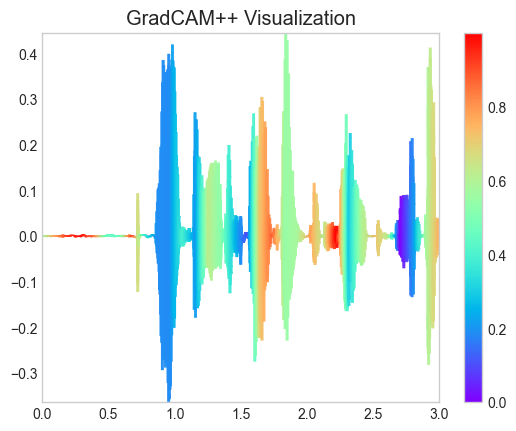

In [194]:
x = np.linspace(0, 3, input_tensor.shape[0])
multicolored_lines(x, input_tensor, output, f"GradCAM++ Visualization")